# Deconvolute Bladder cancer transcriptome data

This jupyter notebook analyzes 433 bulk transcriptome profiling data from the TCGA Bladder Urothelial Carcinoma project. Use our single-cell Bladder cancer data as reference dataset, which combined ~50,000 cells from 11 patients'19 specimens.

## Table of contents:

  * <a href=#Install_load_Packages>0 Install and load packages</a>
  * <a href=#Download>1 Access to TCGA data</a>
  * <a href=#Preprocessing>2 Process TCGA data and visualization</a>
    * <a href=#PCA>2.1 Perform linear dimensional reduction</a>
    * <a href=#UMAP>2.2 Clustering and Visualization</a>
  * <a href=#MuSiC>3 Deconvolution by MuSiC</a>

<a id="Install_load_Packages"></a>

## 0. Installation

In [2]:
version

               _                           
platform       x86_64-conda_cos6-linux-gnu 
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.2                         
year           2019                        
month          12                          
day            12                          
svn rev        77560                       
language       R                           
version.string R version 3.6.2 (2019-12-12)
nickname       Dark and Stormy Night       

In [2]:
if (!"BiocManager" %in% rownames(installed.packages()))
  install.packages("BiocManager")
if (!"TCGAWorkflow" %in% rownames(installed.packages())) 
    BiocManager::install("TCGAWorkflow")
if (!"Seurat" %in% rownames(installed.packages()))
    install.packages("Seurat")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'TCGAWorkflow'



### Load packages

TCGAWorkflowData: this package contains the data needed to perform each analysis step. This is a subset of the download to make the examples faster. For the real analysis, use all available data.

Seurat: We will use it to calculate the dimension reduction plot and visualize the results.

In [4]:
library(TCGAWorkflowData)
library(TCGAbiolinks)

library(Seurat)
library(DT)
library(SummarizedExperiment)
library(ggplot2)
library(scater)
library(MuSiC)
library(xbioc)
library(heatmaply)

ERROR: Error in library(MuSiC): there is no package called ‘MuSiC’


In [ ]:
source("https://raw.githubusercontent.com/nyuhuyang/SeuratExtra/master/R/Seurat3_functions.R")

<a id="Download"></a>

# 1 Access to the TCGA data

### Introduction

Recent technological developments have made it possible to deposit large amounts of genomic data, such as gene expression, into freely available public international consortia such as the Cancer Genome Atlas (TCGA).

The Cancer Genome Atlas (TCGA) is an initiative of the National Institutes of Health (NIH) that makes publicly available molecular and clinical information on more than 30 human cancers, including exomes (mutation analysis), single nucleotide polymorphisms (SNPs), DNA methylation, transcriptomes (mRNAs), microRNAs (miRNAs), and proteomes. The TCGA makes available The sample types are: primary solid tumor, recurrent solid tumor, hematogenous normal and tumor, metastatic and solid tissue normal (Weinstein et al., 2013).

### Access to the TCGA-BLCA data

Here we will use TCGA Bladder Urothelial Carcinoma project https://portal.gdc.cancer.gov/projects/TCGA-BLCA as an example. TCGA-BLCA contains 412 cases and 12,513 files. We will only focus on Transcriptome Profiling (RNA-seq) data.

![TCGA-BLCA](TCGA.png)

In [4]:
query.exp <- GDCquery(project = "TCGA-BLCA",
                      data.category = "Gene expression",
                      data.type = "Gene expression quantification",
                      platform = "Illumina HiSeq", 
                      file.type  = "results", 
                      #sample.type = "Primary solid Tumor",
                      legacy = TRUE)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg19

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-BLCA

--------------------

oo Filtering results

--------------------

ooo By platform

ooo By data.type

ooo By file.type

----------------

oo Checking data

----------------

ooo Check if there are duplicated cases

ooo Check if there results for the query

-------------------

o Preparing output

-------------------



In [5]:
GDCdownload(query.exp)


Of the 433 files for download 433 already exist.

All samples have been already downloaded



In [6]:
exp <- GDCprepare(query.exp, save = FALSE)

  |======================================================================| 100%

Accessing grch37.ensembl.org to get gene information


Warning message:
“`select_()` is deprecated as of dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`filter_()` is deprecated as of dplyr 0.7.0.
Please use `filter()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Cache found

Starting to add information to samples

 => Add clinical information to samples

Add FFPE information. More information at: 
=> https://cancergenome.nih.gov/cancersselected/biospeccriteria 
=> http://gdac.broadinstitute.org/runs/sampleReports/latest/FPPP_FFPE_Cases.html

 => Adding subtype information to samples

blca subtype information from:doi:10.1016/j.cell.2017.09.007



In [7]:
exp

class: RangedSummarizedExperiment 
dim: 19947 433 
metadata(1): data_release
assays(2): raw_count scaled_estimate
rownames(19947): A1BG|1 A2M|2 ... TMED7-TICAM2|100302736
  LOC100303728|100303728
rowData names(4): gene_id entrezgene ensembl_gene_id
  transcript_id.transcript_id_TCGA-BL-A13J-01B-04R-A277-07
colnames(433): TCGA-BL-A13J-01B-04R-A277-07
  TCGA-KQ-A41N-01A-11R-A33J-07 ... TCGA-4Z-AA7Q-01A-11R-A39I-07
  TCGA-4Z-AA89-01A-11R-A39I-07
colData names(242): sample patient ... subtype_Fusion.in.TNFRSF21
  subtype_Fusion.in.ASIP

In [8]:
assays(exp)[[1]][1:4,1:4]

,TCGA-BL-A13J-01B-04R-A277-07,TCGA-KQ-A41N-01A-11R-A33J-07,TCGA-XF-A9T8-01A-11R-A39I-07,TCGA-GC-A6I3-11A-11R-A31N-07
A1BG|1,95.65,114.96,59.87,571.94
A2M|2,9942.60,5498.62,22935.83,69771.23
NAT1|9,33.00,14.00,182.00,105.00
NAT2|10,0.00,0.00,1.00,2.00


In [13]:
genes = gsub("\\|.*","",rownames(assays(exp)$raw_count))

In [15]:
raw_count <- assays(exp)$raw_count[!duplicated(genes),]

In [17]:
rownames(raw_count) = gsub("\\|.*","",rownames(raw_count))

<a id="Preprocessing"></a>

# 2 Process TCGA data and visualization

In [19]:
BLCA_seurat <- CreateSeuratObject(counts = raw_count, project = "TCGA-BLCA",
                                  meta.data = as.data.frame(colData(exp)))

In [20]:
BLCA_seurat <- NormalizeData(BLCA_seurat)

In [21]:
BLCA_seurat <- FindVariableFeatures(BLCA_seurat, selection.method = "vst", nfeatures = 2000)

In [22]:
all.genes <- rownames(BLCA_seurat)
BLCA_seurat <- ScaleData(BLCA_seurat, features = all.genes)

Centering and scaling data matrix



<a id="PCA"></a>

## 2.1 Perform linear dimensional reduction

In [23]:
BLCA_seurat <- RunPCA(BLCA_seurat, features = VariableFeatures(object = BLCA_seurat))

PC_ 1 
Positive:  ANXA6, CALD1, FLNA, ITGA5, FERMT2, PALLD, CCDC80, COL6A2, CLIC4, TGFB1I1 
	   PDLIM3, MSRB3, EMILIN1, FBN1, FGL2, ZCCHC24, TPM2, FILIP1L, VIM, TPM1 
	   MYL9, COL6A1, NEXN, MYLK, DPYSL3, GPR124, CFL2, TAGLN, CTGF, DCN 
Negative:  VSIG2, FAM174B, FGFR3, FOXQ1, SLITRK6, DHRS2, LOC284837, POF1B, MYCL1, FBP1 
	   BCAS1, GPX2, CYP4F22, SEMA6A, HMGCS2, AGR2, PLA2G2F, FAM3B, ERBB2, BTBD16 
	   CYP4F12, CYP4B1, UGT1A6, EPHB6, TBX1, CYP2J2, KLHDC7A, HSD17B2, PSCA, UPK2 
PC_ 2 
Positive:  KRT6A, KRT6B, KRT5, DUSP7, CDH3, TYMP, KRT6C, SERPINB1, IGF2BP2, KRT14 
	   BNC1, WARS, DSG3, GSDMC, CTSC, CDC25B, IL1RAP, DSP, LAMC2, SAMD9 
	   KRT16, S100A8, LAMA3, IL20RB, PKP1, CD109, DSC3, VSNL1, S100A2, PPP1R14C 
Negative:  GCOM1, BTG2, RGS5, FBLN1, PLIN4, SLIT3, PGM5, AQP1, UPK2, ITIH5 
	   TBX2, VSIG2, CACNA1H, PPP1R12B, DHRS2, TMPRSS2, C8orf84, TACC1, UPK1A, AOC3 
	   SPINK1, RCAN2, HSPB6, CACNA1C, MRVI1, PDK4, SORBS2, SORBS1, LMOD1, TMEM97 
PC_ 3 
Positive:  SLAMF8, APOC1, APOE, LIL

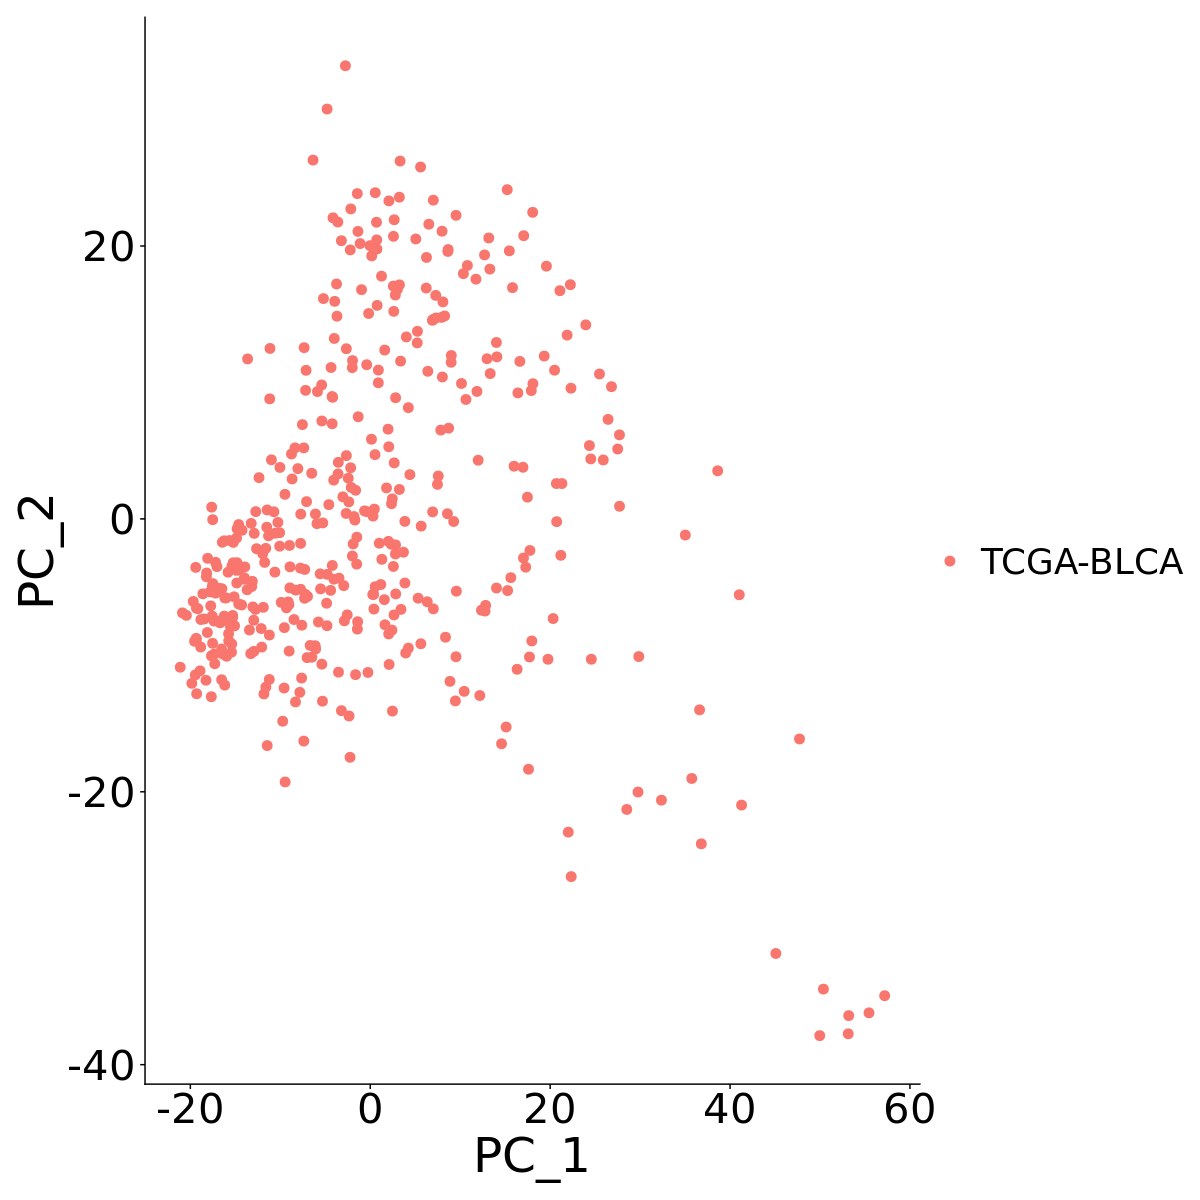

In [24]:
options(repr.plot.width = 12, repr.plot.height = 12,repr.plot.res = 100)
IncreaseTextSize <- theme(text = element_text(size = 30),
      axis.text = element_text(size = 30),
     axis.title = element_text(size = 35))
DimPlot(BLCA_seurat, reduction = "pca",pt.size = 3) + IncreaseTextSize

NULL

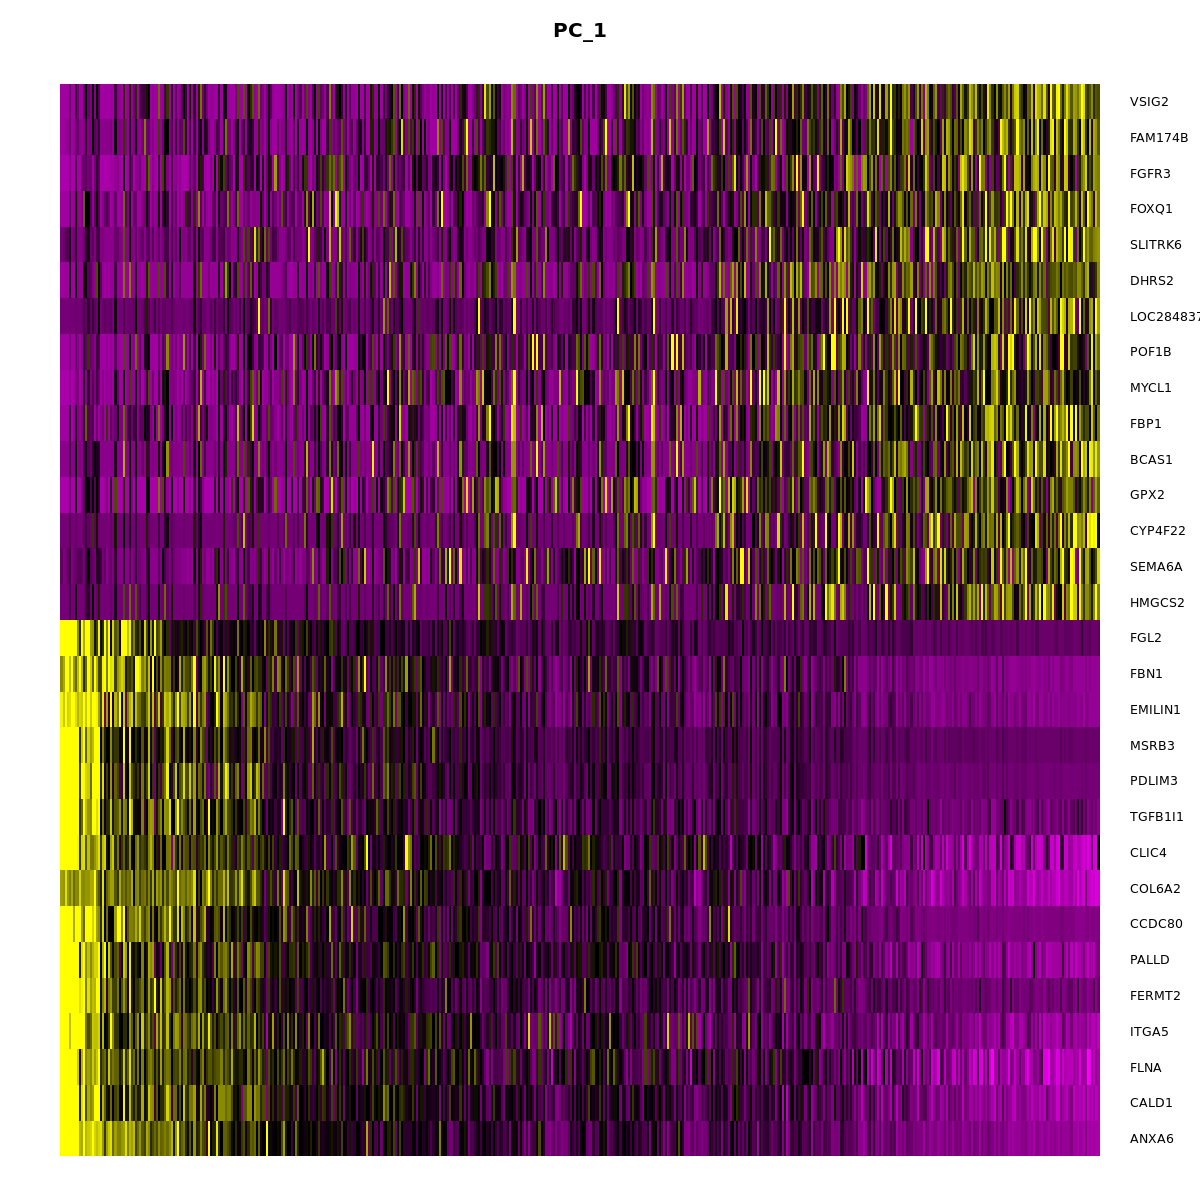

In [34]:
DimHeatmap(BLCA_seurat, dims = 1, cells = 500, balanced = TRUE)

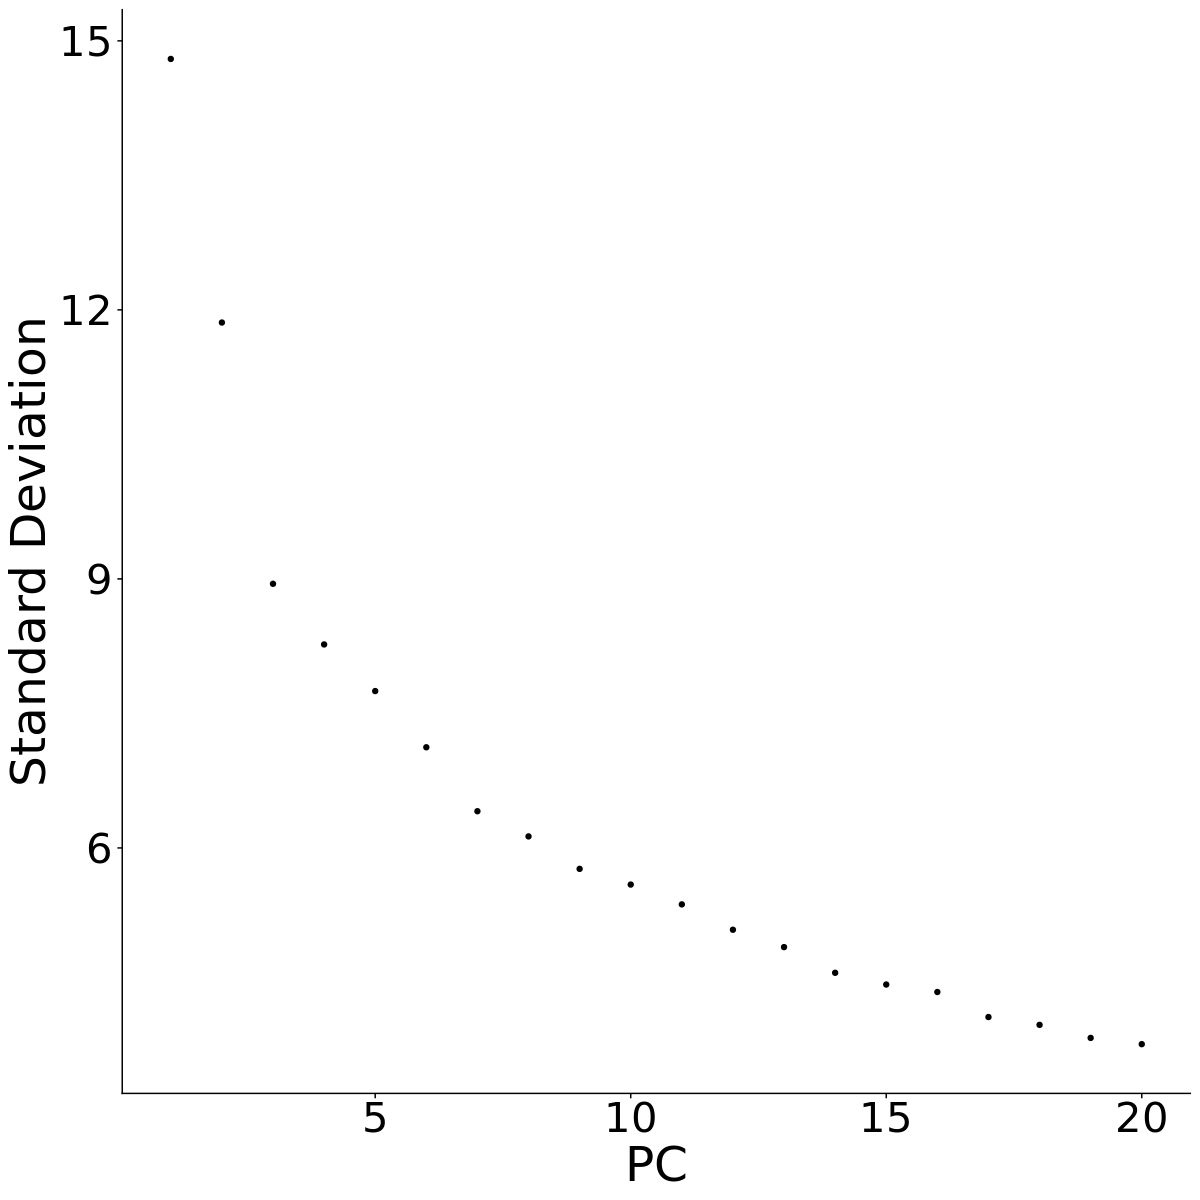

In [26]:
ElbowPlot(BLCA_seurat) + IncreaseTextSize

<a id="UMAP"></a>

## 2.2 Clustering and Visualization

In [27]:
BLCA_seurat <- FindNeighbors(BLCA_seurat, dims = 1:20)
BLCA_seurat <- FindClusters(BLCA_seurat, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 433
Number of edges: 14755

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7260
Number of communities: 4
Elapsed time: 0 seconds


In [28]:
BLCA_seurat <- RunUMAP(BLCA_seurat, dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:57:48 UMAP embedding parameters a = 0.9922 b = 1.112

17:57:48 Read 433 rows and found 20 numeric columns

17:57:48 Using Annoy for neighbor search, n_neighbors = 30

17:57:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:57:48 Writing NN index file to temp file /scratchLocal/yah2014_5481051/Rtmp57kDGM/file1a0e7c3e5adc

17:57:48 Searching Annoy index using 1 thread, search_k = 3000

17:57:48 Annoy recall = 100%

17:57:49 Commencing smooth kNN distance calibration using 1 thread



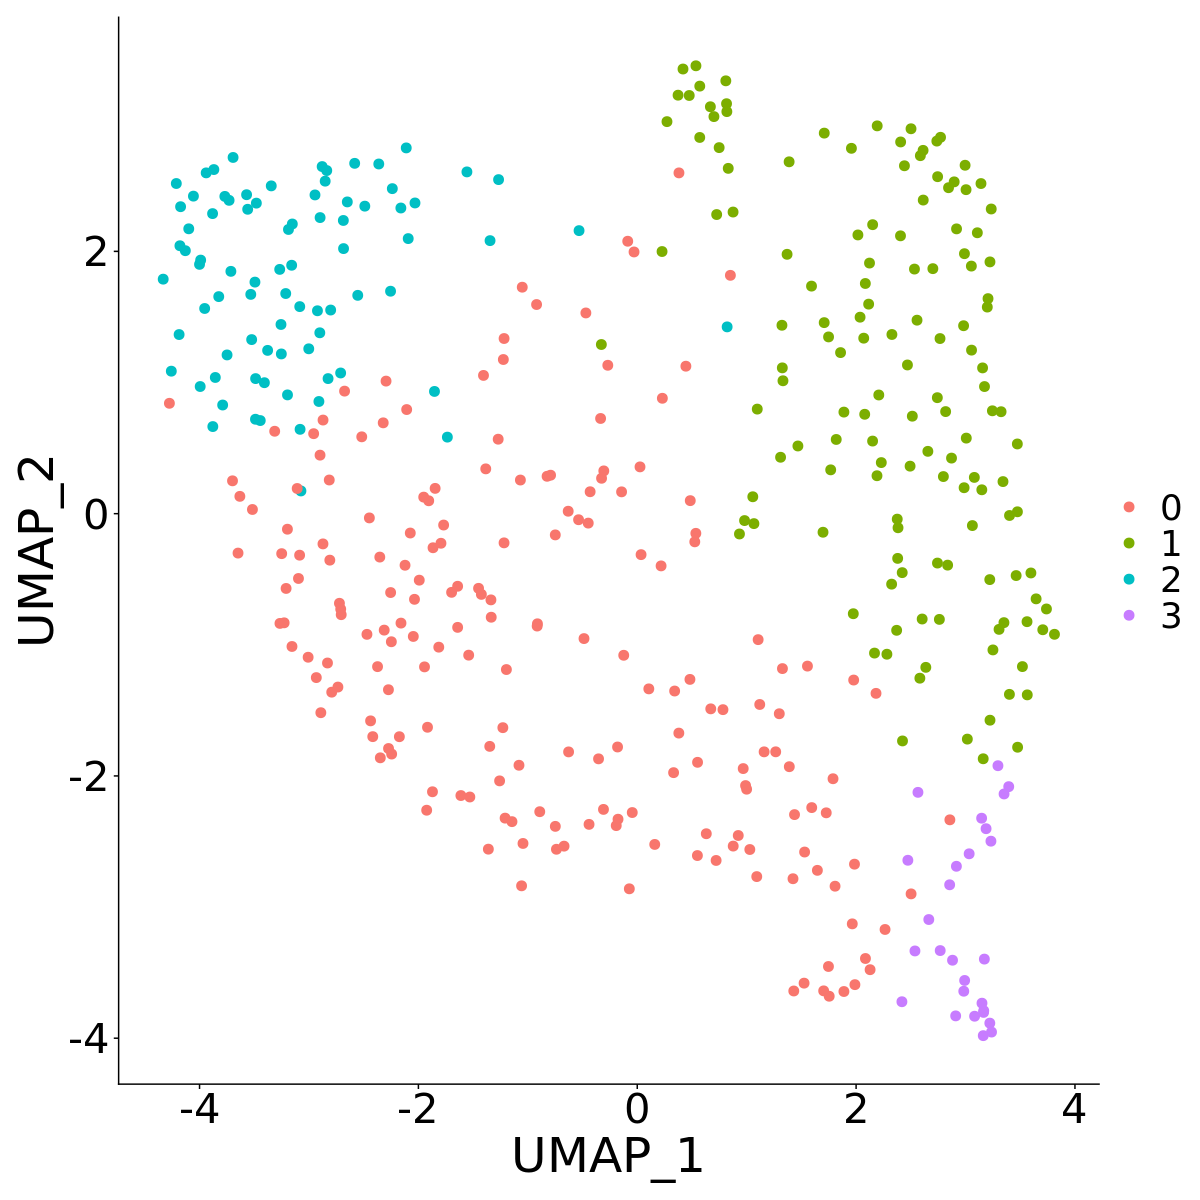

In [29]:
DimPlot(BLCA_seurat, reduction = "umap",pt.size = 3) + IncreaseTextSize

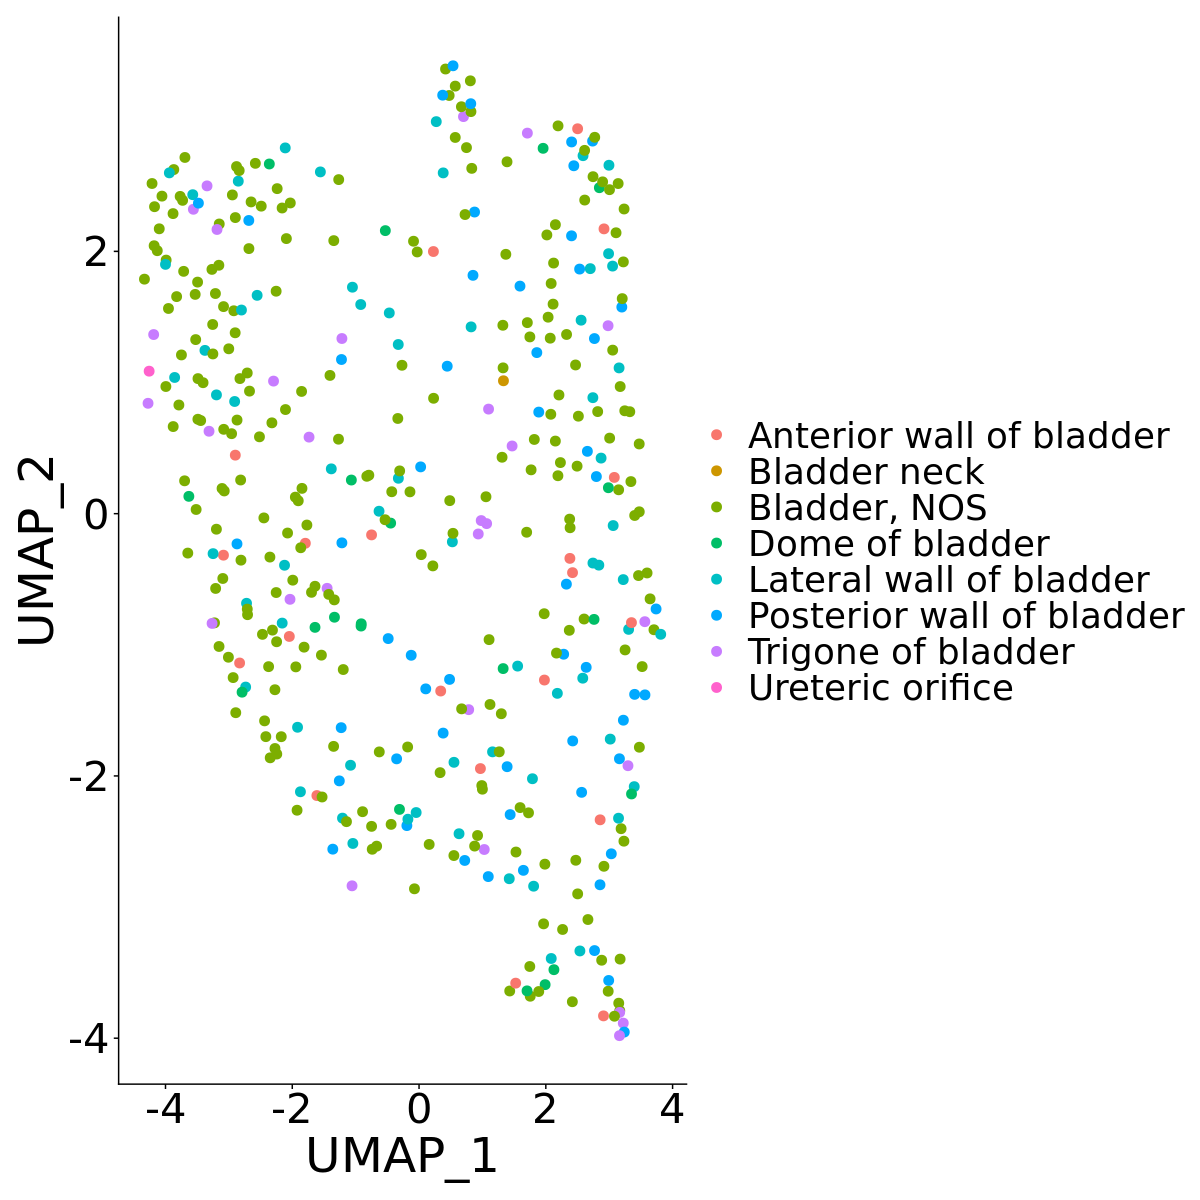

In [30]:
DimPlot(BLCA_seurat, reduction = "umap", group.by = "tissue_or_organ_of_origin",
        pt.size = 3) + IncreaseTextSize

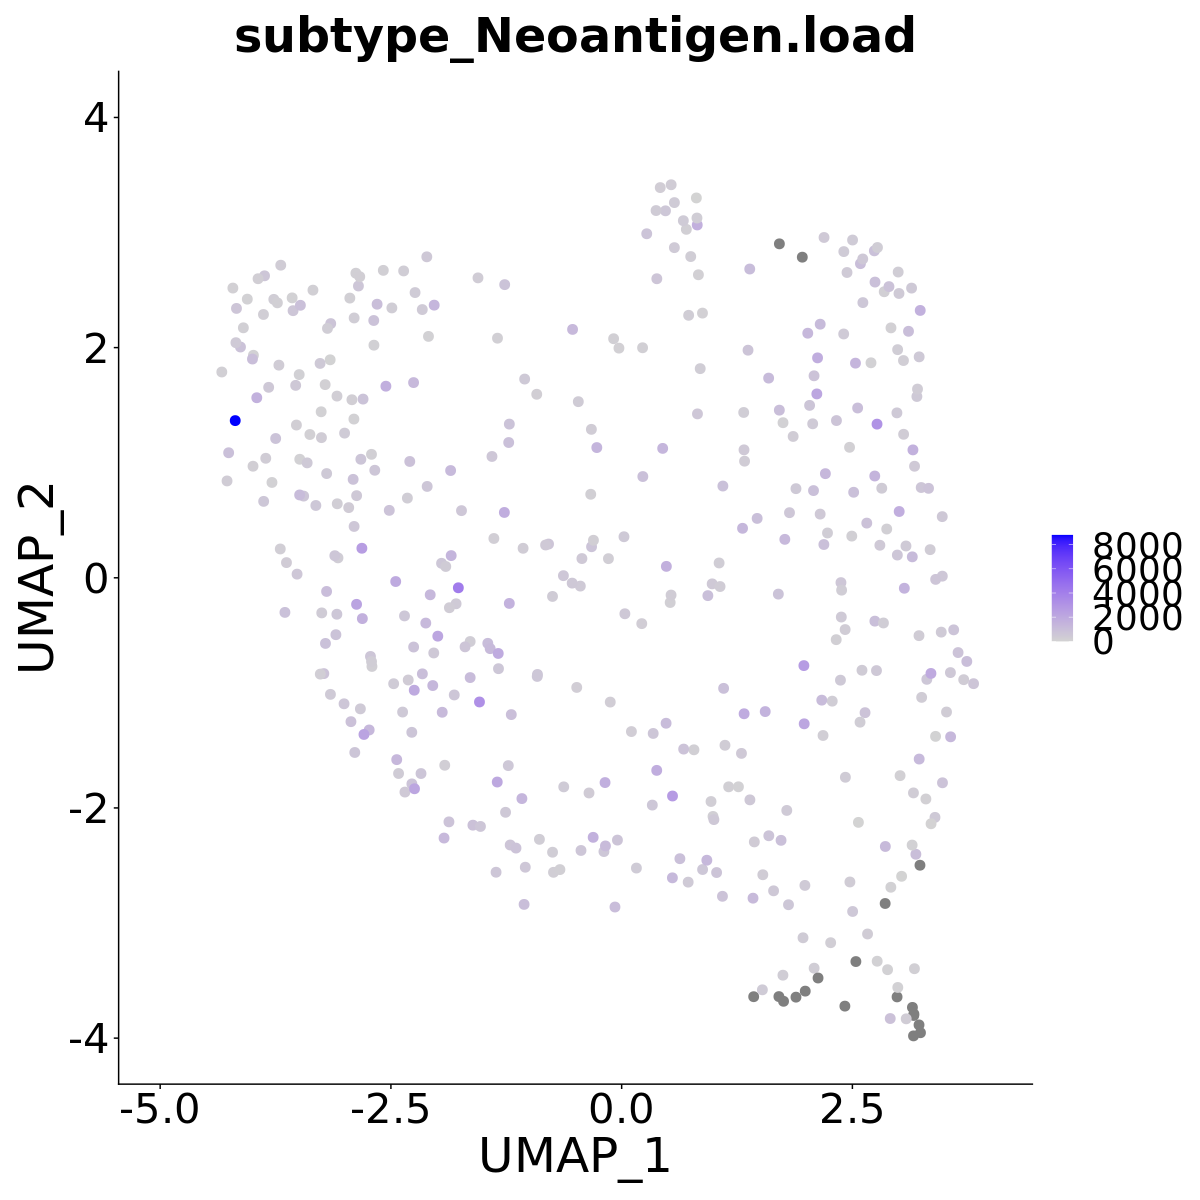

In [31]:
FeaturePlot(BLCA_seurat, features = "subtype_Neoantigen.load",
            pt.size = 3) + IncreaseTextSize

In [32]:
saveRDS(BLCA_seurat, file = "../data/20200920_TCGA-BLCA.rds")

<a id="MuSiC"></a>

# 3 Deconvolution by MuSiC

In [33]:
# read BladderCancerImmune data
BLCA_seurat = readRDS("../data/20200920_TCGA-BLCA.rds")

In [25]:
# convert TCGA-BLCA counts to a ExpressionSet object
BLCA.sce <- new("ExpressionSet", exprs = as.matrix(BLCA_seurat[["RNA"]]@counts),
               phenoData = AnnotatedDataFrame(BLCA_seurat@meta.data))

In [8]:
# read BladderCancerImmune data
scBLCA_seurat = readRDS("../data/20200914_BladderCancerImmune.rds")

In [10]:
scBLCA.sce <- new("ExpressionSet", exprs = as.matrix(scBLCA_seurat[["RNA"]]@counts),
                                 phenoData = AnnotatedDataFrame(scBLCA_seurat@meta.data))

In [11]:
table(scBLCA.sce$labels)


                      Adipocytes                       Astrocytes 
                            1509                              584 
                  B cells, naive                     Chondrocytes 
                            1315                              154 
                             CLP                              CMP 
                            1177                               49 
                              DC                Endothelial cells 
                             205                              234 
                     Eosinophils                 Epithelial cells 
                             122                             2856 
                    Erythrocytes                      Fibroblasts 
                             387                             4691 
                             GMP                              HSC 
                              22                               59 
                   Keratinocytes                      Macroph

In [ ]:
BLCA.prop.main = music_prop(bulk.eset = BLCA.sce, sc.eset = scBLCA.sce,
                       clusters = "main_labels",
                       samples = 'orig.ident', 
                       verbose = T)

In [50]:
saveRDS(BLCA.prop.main, file = "data/20200929_TCGA-BLCA.prop_main.rds")

NULL

In [20]:
BLCA.prop_main = readRDS("../data/20200929_TCGA-BLCA.prop_main.rds")

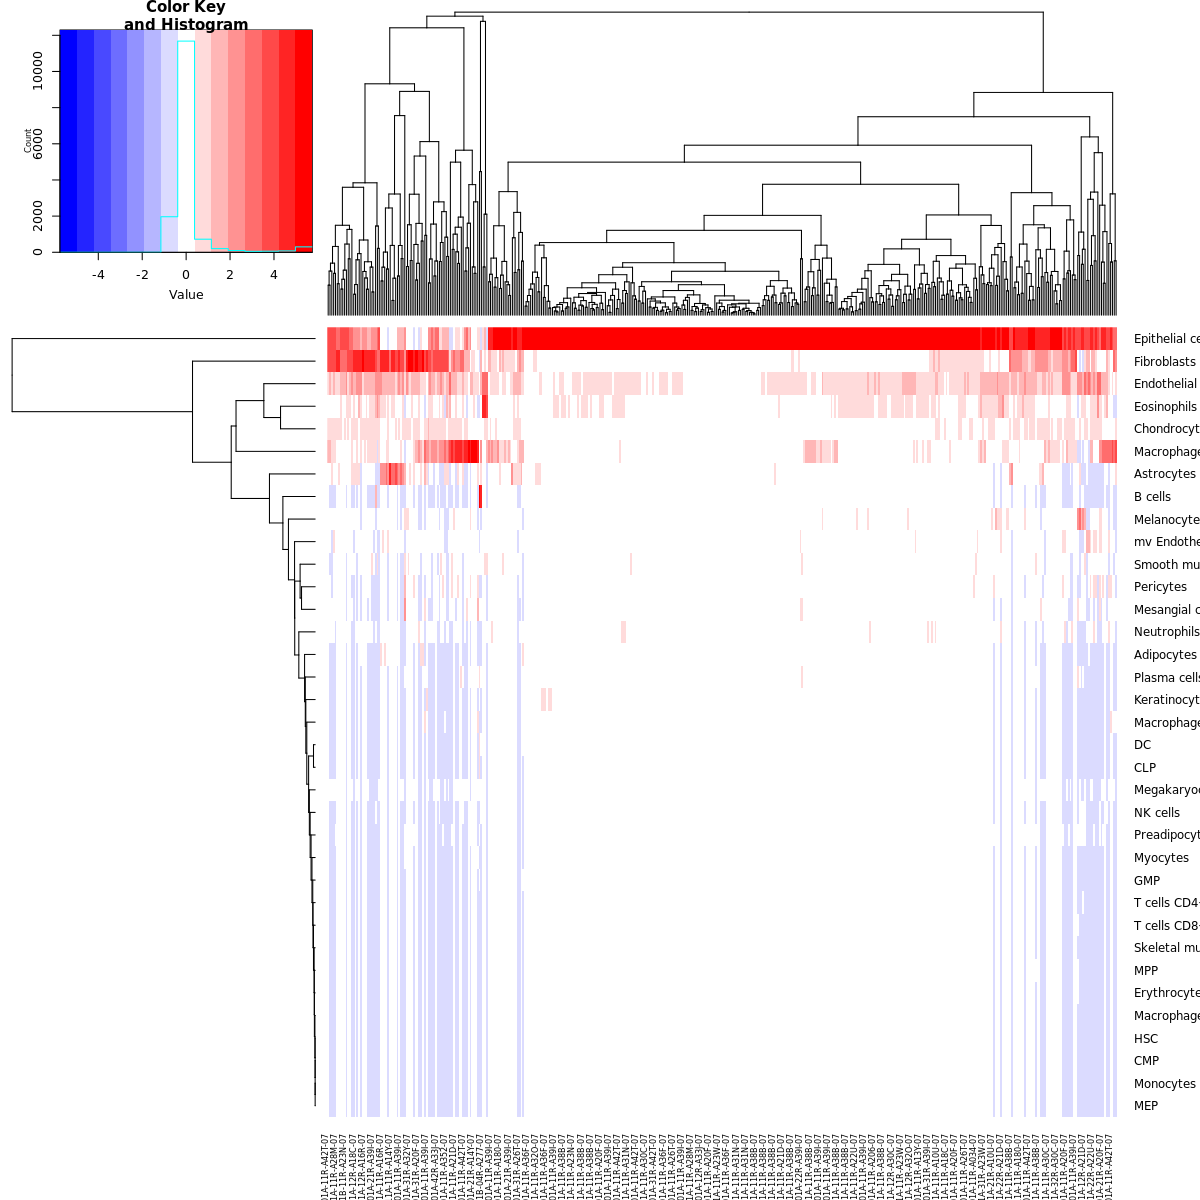

In [21]:
heatmap.2(scale(t(BLCA.prop_main$Est.prop.weighted),scale = TRUE), Colv = TRUE, Rowv= TRUE,trace ="none",
          dendrogram = "both",col = bluered)

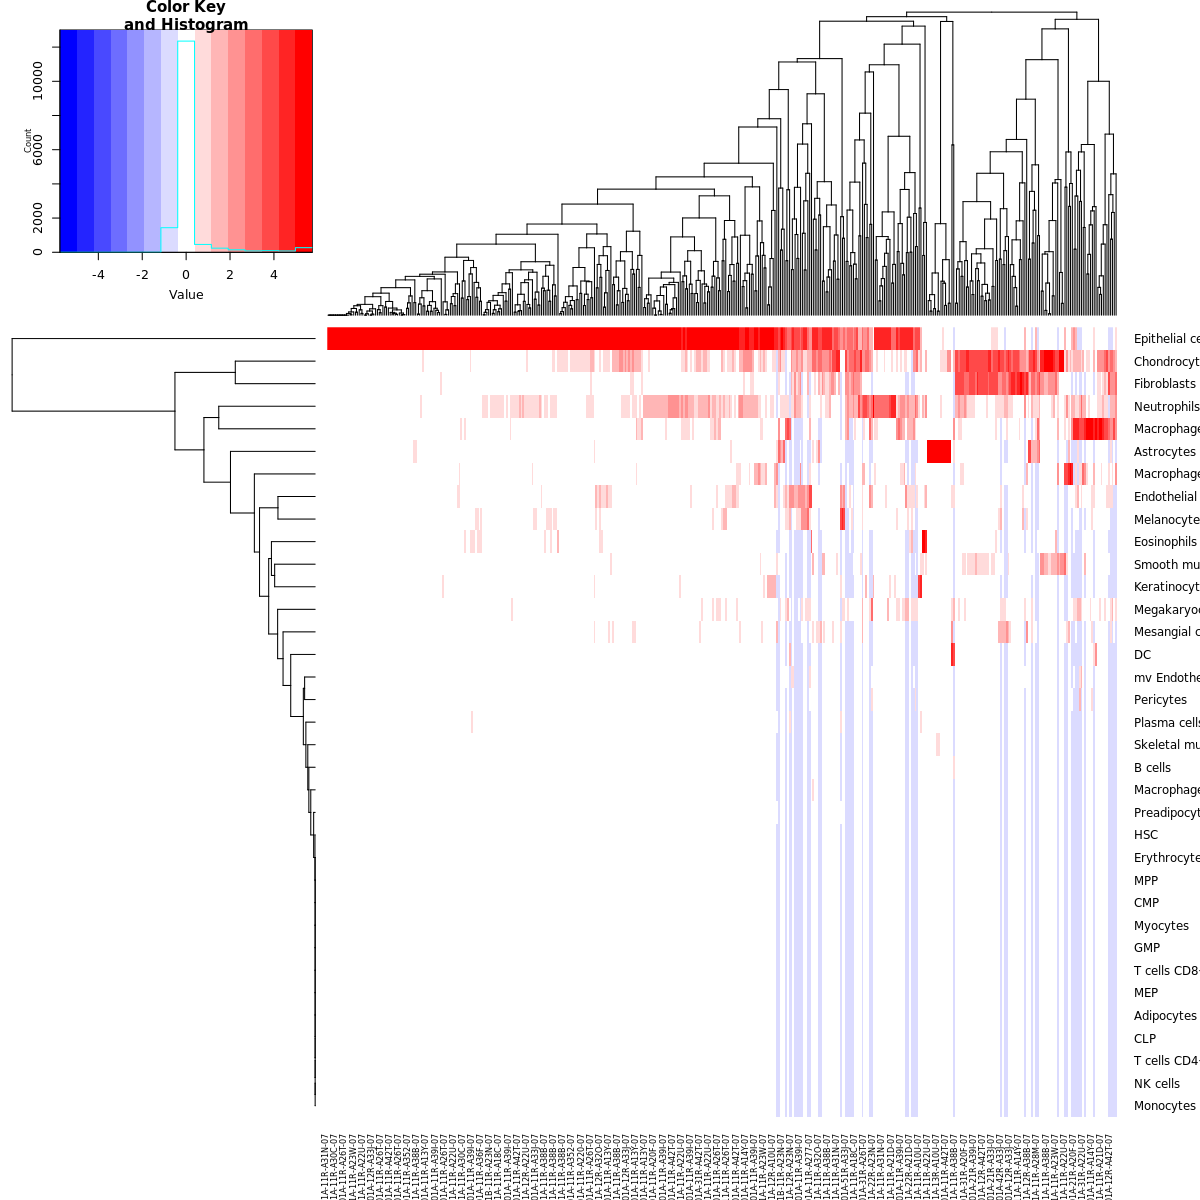

In [22]:
heatmap.2(scale(t(BLCA.prop_main$Est.prop.allgene),scale = TRUE), Colv = TRUE, Rowv= TRUE,trace ="none",
          dendrogram = "both",col = bluered)